In [1]:
import torch
import torch.nn as nn
import pandas as pd
from chessEngine import ChessEncoder, MLPEngine
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

# Preprocessing

In [2]:
df = pd.read_csv('fen_analysis.csv').sample(frac=1)[:50000] # This shuffles the rows
# df = pd.read_csv('fen_analysis.csv')[:30000] # no shuffle
df

,fen_value,score
70272,r4rk1/5p1p/4bnpb/ppp1p3/3nP3/P2PN2P/1P2BPPN/1R...,-67
308491,r3qrk1/pppbppbp/2np1np1/5P2/3PP1P1/7P/PPP1N1B1...,-137
272055,rnbqkb1r/ppp2ppp/5n2/8/3Np3/2N5/PPP2PPP/R1BQKB...,-22
94511,r2q1rk1/4n1pp/p1pbnp2/1p1p4/5P2/PP1PP3/1BPN2PP...,209
322722,rnb1kb1r/ppp2ppp/8/8/8/2PBBN2/Pq3PPP/R2QK2R w ...,165
...,...,...
169452,6n1/7K/1p2k1p1/p1p2p2/P7/1P1P1N1P/2P2PP1/8 b -...,-444
68169,r1bqkbnr/pp1p1ppp/2n1p3/2p5/2B1P3/3P1N2/PPP2PP...,31
330423,8/p1K5/Pp1p1k1p/1r3p2/6p1/8/7P/4R3 w - - 0 44,-318
105821,2r1r1k1/pp2ppbp/1q1p1np1/3P4/5N2/1P4P1/PBPQ1P1...,-494


In [3]:
encoder_object = ChessEncoder()

In [4]:
fen_encodings = []
for fen_i in df['fen_value']:
    encoded_fen = encoder_object.encode_fen(fen_i)
    fen_encodings.append(encoded_fen)

In [5]:
X = torch.tensor(fen_encodings, dtype=torch.int32)

In [6]:
X

tensor([[ 9,  0,  0,  ...,  0, 29, 29],
        [ 9,  0,  0,  ...,  0, 39, 39],
        [ 9, 11, 10,  ...,  0, 37, 38],
        ...,
        [ 0,  0,  0,  ...,  0,  7, 11],
        [ 0,  0,  9,  ...,  0, 30, 35],
        [ 9, 11,  0,  ...,  0, 36, 35]], dtype=torch.int32)

In [7]:
score_encodings = []
for y_i in df['score']:
    # print(y_i)
    encoded_score = encoder_object.encode_score(str(y_i))
    score_encodings.append(encoded_score)
y = torch.tensor(score_encodings, dtype=torch.float32)

In [8]:
X.shape, y.shape

(torch.Size([50000, 200]), torch.Size([50000]))

# Helper Functions

In [9]:
val_split = 10000
test_split = 10000

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
def get_batch(X, Y, bs):
    
    assert isinstance(X, torch.Tensor)
    assert isinstance(Y, torch.Tensor)

    batch = torch.randint(0, len(X), (bs,))
    x = X[batch].to(device)
    y = Y[batch].to(device).to(torch.float32)
    return x, y
# b = get_batch(X, y, 64)

In [ ]:
X_val = X[:val_split].to(device)
y_val = y[:val_split].to(device)
X_test = X[val_split:val_split+test_split].to(device)
y_test = y[val_split:val_split+test_split].to(device)
X = X[val_split+test_split:]
y = y[val_split+test_split:]

In [13]:
len(X)

40000

# Training

In [14]:
# hyperparameters
lr = 0.1
num_steps = 2000
warmup_steps = 50
bs = len(X)
# allowed_error = 100 #
d1 = {1:10, 2:20}
if bs > len(X): bs = len(X)

In [15]:
from torch.optim.lr_scheduler import LambdaLR


In [16]:
 # i accidenly used a smaller lr for scheduler and it worked better, maybe try it?

In [17]:
model = MLPEngine(embedding_dim=64).to(device)
loss_category = nn.MSELoss()
optimiser = torch.optim.AdamW(
            model.parameters(), 
            lr = lr,
            betas=(0.9, 0.999),
            eps=1e-3,
            weight_decay=1e-5)

# Define warm-up and decay
def lr_lambda(epoch):
    if epoch < warmup_steps:  
        return epoch / warmup_steps
    else:  # Exponential decay after warm-up
        return 0.99 ** (epoch - warmup_steps)

scheduler = LambdaLR(optimiser, lr_lambda)
model = model
model.compile()

In [18]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True
torch.set_float32_matmul_precision('high')

In [19]:
train_history = {}
val_history = {}
start_step = 0

In [20]:
model.train()
# train_history = {}
# val_history = {}
for step_i in range(num_steps):
    tot_step = step_i + start_step
    optimiser.zero_grad()
    x_batch, y_batch = get_batch(X, y, bs) 
    # print(x_batch, y_batch)
    y_pred = model(x_batch).view(bs)
    # print(y_pred.shape, y_batch.shape)
    loss = loss_category(y_pred, y_batch)
    # print(loss.item())
    train_history[tot_step] = loss.item()
    loss.backward()
    optimiser.step()
    scheduler.step()
    # print(f"Epoch {step_i}, Learning Rate: {scheduler.get_last_lr()}")
    print(tot_step, ': ',loss.item())

    if tot_step % 100 == 0:
        # validation phase
        y_pred = model(X_val).view(val_split)
        # print(y_pred.shape, y_batch.shape)
        loss = loss_category(y_pred, y_val)
        # print(loss.item())
        val_history[tot_step] = loss.item()

start_step += num_steps

0 :  3106815.75
1 :  3067983.5
2 :  3044161.75
3 :  3245371.0
4 :  3117408.5
5 :  3133832.0
6 :  3100303.75
7 :  3151415.75
8 :  3080605.0
9 :  3103887.5
10 :  3142175.25
11 :  3045945.0
12 :  3075293.0
13 :  3131140.0
14 :  3048130.75
15 :  3037180.75
16 :  2913556.5
17 :  2954570.5
18 :  2861989.5
19 :  3024016.0
20 :  3044999.75
21 :  3031150.5
22 :  3002358.0
23 :  2963100.5
24 :  2869249.5
25 :  2990531.75
26 :  2771144.75
27 :  2922617.75
28 :  2847617.25
29 :  2844083.0
30 :  2789922.75
31 :  2592740.25
32 :  2507361.75
33 :  2433049.25
34 :  2315415.5
35 :  2216322.5
36 :  2189535.5
37 :  1976909.625
38 :  2031753.125
39 :  1833608.375
40 :  1760097.625
41 :  1612379.25
42 :  1565806.0
43 :  1364115.5
44 :  1222801.625
45 :  1094349.0
46 :  943533.875
47 :  853463.6875
48 :  642886.25
49 :  566715.6875
50 :  461273.34375
51 :  341709.1875
52 :  314642.71875
53 :  243745.171875
54 :  202650.3125
55 :  184753.328125
56 :  188595.921875
57 :  186640.828125
58 :  219410.890625
59 :

KeyboardInterrupt: 

In [21]:
torch.save(model.state_dict(), 'saves/bad_model.pt')

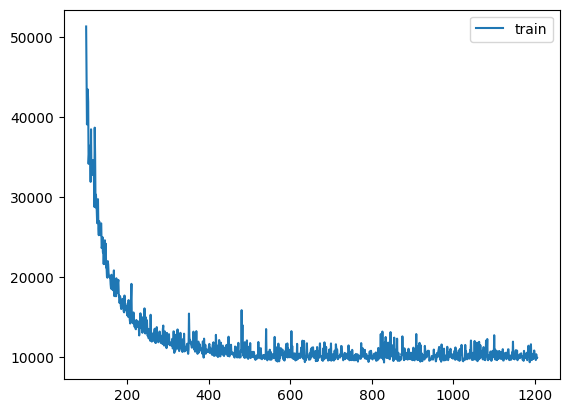

In [22]:
plt.plot(list(train_history.keys())[100:], list(train_history.values())[100:], label='train')
# plt.plot(val_history.keys(), val_history.values(), label='validation')
plt.legend()
plt.show()

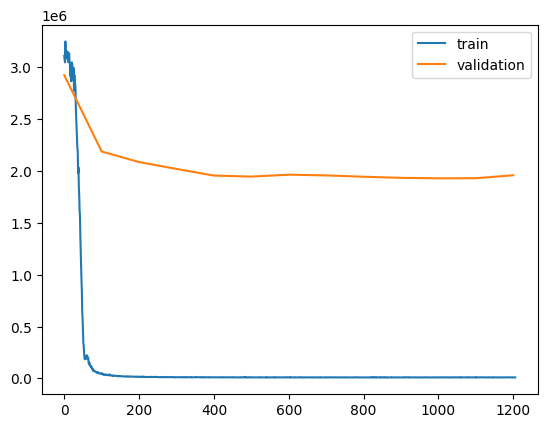

In [23]:
plt.plot(list(train_history.keys()), list(train_history.values()), label='train')
plt.plot(val_history.keys(), val_history.values(), label='validation')
plt.legend()
plt.show()

In [ ]:
'''
# My results
At relu, model is stuck around 25k with 3x1000 steps with xavier
AT relu, moedl went to 9k and then exploded at 3x1000 steps with kaiming; then at 14k
At gelu, model is stuck atound 10k

Adam is better than AdamW for this task
'''

'\n# My results\nAt relu, model is stuck around 25k with 3x1000 steps with xavier\nAT relu, moedl went to 9k and then exploded at 3x1000 steps with kaiming; then at 14k\nAt gelu, model is stuck atound 10k\n\nAdam is better than AdamW for this task\n'

# TO DO

- [x] do inference, and run a partially trained model with the GUI intact
- [x] **find a way to fix the fact that our model is giving integer loss
- [x] **Fix the bug in initialisation
- [ ] implement weights and biases or tensorboard 
- [ ] improve the model
  - [ ] get a better/ bigger dataset
  - [ ] hyperparameter and architecture
    - [x] better encoding
    - [ ] residual connections
    - [ ] try adamW after tuning b1 and b2
    - [ ] increase embedding dim
    - [x] increase neurons in the layers
    - [x] increase layers in the network
    - [x] change loss function (maybe)
    - [ ] try diff learning rate scheduler(trapeziodal)
    - [ ] Add regularisation
      - [ ] l1,l2
      - [x] dropout
    - [x] Better initialisation
    - [x] diff optimisation algorithm

# Note

- some issue after the whole architecture was changed in gui file.
- also the dataset is bad, look for a new one. 